# Contents

In this notebook, I induce Rabi oscillation on the (01) subspace of the superconducting qutrit.

In [3]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider
import utility as ut
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [3]:
plt.rcParams['axes.linewidth'] = 1.1
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

In [5]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

qubit = 1
cbit = 0

num_qubits = int(qubit+1)
num_cbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')

f01 = 4.8151 GHz
f12 = 4.5054 GHz


# Round 1

Here lies the script

In [6]:
dur = 8*4

amplitudes = np.linspace(-0.75, 0.75, 100)

rabi_gate = qiskit.circuit.Gate('rabi_gate', weight, [])

rabi_osc_circs = []

for amp in amplitudes:

    with qiskit.pulse.build(backend=backend) as rabi_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_01_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur, amp=amp, sigma=int(dur/4)), drive_chan)

    rabi_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    rabi_circ.append(rabi_gate, [qubit])
    rabi_circ.measure(qubit, cbit)
    rabi_circ.add_calibration(rabi_gate, [qubit], rabi_sched)

    rabi_osc_circs.append(rabi_circ)

num_shots = int(2**13)

In [5]:
rabi_job = backend.run(rabi_osc_circs, meas_level=1, meas_return='avg', shots=num_shots)
rabi_job.job_id()

'csc8r50ca010008x84y0'

In [6]:
rabi_job = provider.backend.retrieve_job('csc8r50ca010008x84y0')
rabi_exp = ut.DataAnalysis(experiment=rabi_job, average=True, shots=num_shots, qubit=0)
rabi_exp.retrieve_data(average=True)

with open("./characterization/rabi01/data/round1.pkl", "wb") as f:
    pickle.dump(rabi_exp.IQ_data, f)

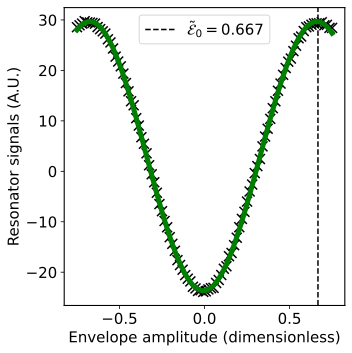

In [16]:
IQdata_round1 = np.load("./characterization/rabi01/data/round1.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(amplitudes, IQdata_round1, lambda x, A, T, phi, B: (A*np.cos(2*np.pi/T*x+phi)+B), [30, 1.2, 0, 0])
ax.scatter(amplitudes, IQdata_round1, marker='x', color='black', s=100)
ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\mathcal{E}}_0=$'+f'{np.round(popt[1]/2,3)}', color='black')
ax.plot(amplitudes, yfit, linewidth=5, color='green')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
ax.set_ylabel('Resonator signals (A.U.)', fontsize=15)
ax.set_xlabel('Envelope amplitude (dimensionless)', fontsize=15)
# ax.set_title('Rabi oscillation on $(1-2)$ subspace', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/rabi01/figs/rabi01_shortpulse.png', dpi=300)

In [13]:
np.round(popt[1]/2,5)

0.66743

# Round 2

In [7]:
dur = 120

amplitudes = np.linspace(-0.75, 0.75, 100)

rabi_gate = qiskit.circuit.Gate('rabi_gate', weight, [])

rabi_osc_circs = []

for amp in amplitudes:

    with qiskit.pulse.build(backend=backend) as rabi_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_01_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur, amp=amp, sigma=int(dur/4)), drive_chan)

    rabi_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    rabi_circ.append(rabi_gate, [qubit])
    rabi_circ.measure(qubit, cbit)
    rabi_circ.add_calibration(rabi_gate, [qubit], rabi_sched)

    rabi_osc_circs.append(rabi_circ)

num_shots = int(2**13)

In [11]:
rabi_job = backend.run(rabi_osc_circs, meas_level=1, meas_return='avg', shots=num_shots)
rabi_job.job_id()

'cscb1xzx35wg0080zmfg'

In [8]:
rabi_job = provider.backend.retrieve_job('cscb1xzx35wg0080zmfg')
rabi_exp = ut.DataAnalysis(experiment=rabi_job, average=True, shots=num_shots, qubit=0)
rabi_exp.retrieve_data(average=True)

with open("./characterization/rabi01/data/round2.pkl", "wb") as f:
    pickle.dump(rabi_exp.IQ_data, f)

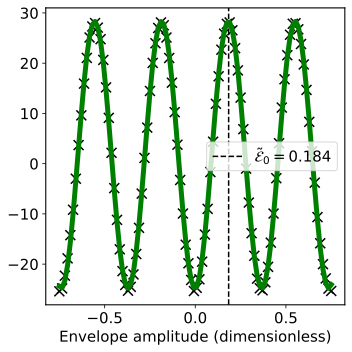

In [18]:
IQdata_round2 = np.load("./characterization/rabi01/data/round2.pkl", allow_pickle=True)

fig, ax = plt.subplots(ncols=1, figsize=(5, 5))
popt, yfit, pcov = ut.fit_function(amplitudes, IQdata_round2, lambda x, A, T, phi, B: (A*np.cos(2*np.pi/T*x+phi)+B), [30, 0.4, 0, 0])
ax.scatter(amplitudes, IQdata_round2, marker='x', color='black', s=100)
ax.axvline(np.round(popt[1]/2,3), linestyle='--', label=r'$\tilde{\mathcal{E}}_0=$'+f'{np.round(popt[1]/2,3)}', color='black')
ax.plot(amplitudes, yfit, linewidth=5, color='green')

ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize=15)
# ax.set_ylabel('Resonator signals (A.U.)', fontsize=15)
ax.set_xlabel('Envelope amplitude (dimensionless)', fontsize=15)
# ax.set_title('Rabi oscillation on $(1-2)$ subspace', fontsize=15)
fig.tight_layout()
fig.savefig('./characterization/rabi01/figs/rabi01_longpulse.png', dpi=300)